# Electron Scattering angle

## CNO neutrino energy distribution

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import urllib.request
from scipy.interpolate import interp1d
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from random import random

In [3]:
#Flux data for N13
f= urllib.request.urlopen("http://www.sns.ias.edu/~jnb/SNdata/Export/CNOspectra/n13.dat")
page1 = f.read().decode("utf-8")
f.close()

linesN = page1.splitlines()

rawflux_n13 = []
rawenergy_n13 = []
for line in range(len(linesN)):
    a = linesN[line]
    rawenergy_n13.append(float(a[3:13]))
    rawflux_n13.append(float(a[15:]))

flux_n13 = []
for n in range(len(rawflux_n13)):
    flux_n13.append(rawflux_n13[n]*2.78e8) 
    

#Flux data from 015
g = urllib.request.urlopen("http://www.sns.ias.edu/~jnb/SNdata/Export/CNOspectra/o15.dat")
page2 = g.read().decode("utf-8")
g.close()

linesO = page2.splitlines()

rawflux_o15 = []
rawenergy_o15 = []
for line in range(len(linesO)):
    a = linesO[line]
    rawenergy_o15.append(float(a[3:13]))
    rawflux_o15.append(float(a[15:]))
    
flux_o15 = []
for n in range(len(rawflux_o15)):
    flux_o15.append(rawflux_o15[n]*2.05e8)
    
    
#Flux data from F17
h = urllib.request.urlopen("http://www.sns.ias.edu/~jnb/SNdata/Export/CNOspectra/f17.dat")
page3 = h.read().decode("utf-8")
h.close()

linesF = page3.splitlines()

rawflux_f17 = []
rawenergy_f17 = []
for line in range(len(linesF)):
    a = linesF[line]
    rawenergy_f17.append(float(a[3:13]))
    rawflux_f17.append(float(a[15:]))

flux_f17 = []
for n in range(len(rawflux_f17)):
    flux_f17.append(rawflux_f17[n]*5.92e6)
    
totenergy = np.linspace(0.0, 1.75, 1000)

totflux = []

n = interp1d(rawenergy_n13, flux_n13, kind = 'cubic', bounds_error = False, fill_value = 0 )

o = interp1d(rawenergy_o15, flux_o15, kind = 'cubic', bounds_error = False, fill_value = 0 )

f = interp1d(rawenergy_f17, flux_f17, kind = 'cubic', bounds_error = False, fill_value = 0 )

for x in totenergy:
    totflux.append(n(x) + o(x) + f(x))

## Solar neutrino flux

In [4]:
def flux(x):
    a = interp1d(totenergy, totflux, kind = 'cubic', bounds_error = False, fill_value = 0)
    return a(x)

from scipy.optimize import fminbound
def minus_flux(x): return -flux(x)
max_flux = fminbound(minus_flux, 0, 1.5)

## Neutrino Generator

In [5]:
def shoot_neutrino(e_max=1.5):
    
    no_exit = True
    
    while(True):
        proposed_energy = random() * e_max
        r = random()
        if r < flux(proposed_energy) / max_flux:
            return proposed_energy

## Electron scattering angle differential cross section

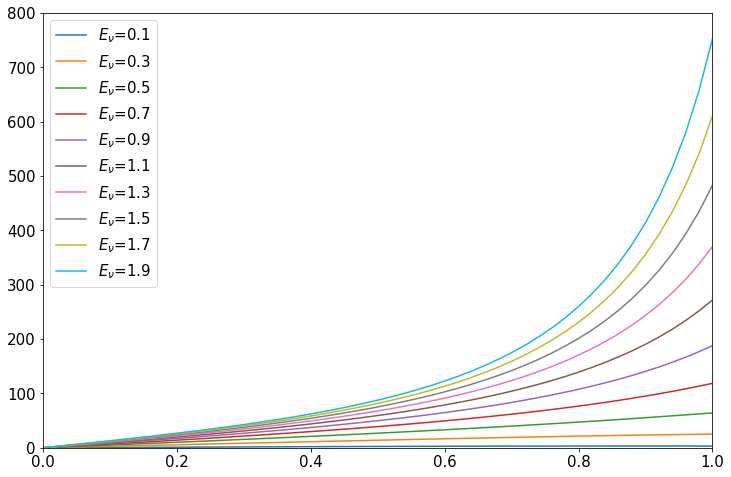

In [6]:
g1 = 0.73
g2 = 0.23
sigma0 = 88.06 #88.06e-46 # cm2
me = 0.511 # Mev

fig1 = plt.figure(figsize=(12,8),facecolor='w')
ax1 = fig1.add_subplot(1,1,1)

# costheta is the cosine of the electron scattering angle, enu is neutrino energy
def anglexsec(costheta, enu):
    return (sigma0)*(4*(enu**2)*((me + enu)**2)*costheta)/(
            (((me + enu)**2)-((enu**2)*(costheta**2)))**2)*(g1**2 + (g2**2)*(
            1-(2*me*enu*(costheta**2))/(((me + enu)**2)-(enu**2)*(
            costheta**2)))**2 - g1*g2*2*(me**2)*(costheta**2)/(
            ((me + enu)**2)-((enu**2)*(costheta**2))))
    
       
for enu in np.arange(0.1, 2.0, 0.2):
    costheta = np.arange(0.0, 1.02, 0.02)
    plt.plot(costheta, anglexsec(costheta, enu), label=r'$E_\nu$='+str(round(enu,1)))
            
plt.xlim(0,1)
plt.ylim(0,800)
plt.legend(loc = 'upper left', fontsize = 15)
plt.tick_params(labelsize=15)

## Electron scattering angle generator

In [7]:
def shoot_electron_costheta(enu):
    
    no_exit = True
    
    while(True):
        proposed_angle = random()
        r = random()
        if r < anglexsec(proposed_angle, enu)/anglexsec(1,enu):
            return proposed_angle

## Angle Counter

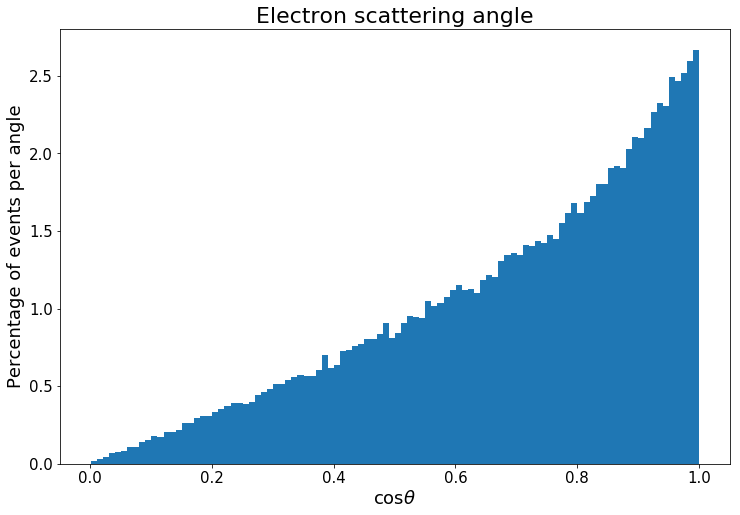

Fraction of events greater than 0.8: 0.4243
Fraction of events greater than 0.9: 0.23924


In [9]:
n_samples_angle = 100000
samples_angle = []
counter_8 = 0
counter_9 = 0
for i in range(0, n_samples_angle):
    neutrino_energy = shoot_neutrino()
    costheta = shoot_electron_costheta(neutrino_energy)
    samples_angle.append(costheta)
    if costheta>0.8:
        if costheta > 0.9:
            counter_8 += 1
            counter_9 += 1
        else:
            counter_8 += 1

fig2 = plt.figure(figsize=(12,8))
ax2 = fig2.add_subplot(1,1,1)

n_tot_events_angle = 100

scale_angle = float(n_tot_events_angle)/n_samples_angle

n, bins, patches = plt.hist(samples_angle, bins=100, weights=len(samples_angle)*[scale_angle])

plt.ylabel('Percentage of events per angle',fontsize=18)
plt.xlabel(r'$\cos\theta$',fontsize=18)
plt.title('Electron scattering angle', fontsize = 22)
plt.tick_params(labelsize=15)
plt.savefig('Electron scattering angle histogram.jpg', dpi = 300)
plt.show()

fractionover8 =(counter_8)/n_samples_angle
fractionover9 =(counter_9)/n_samples_angle

print('Fraction of events greater than 0.8: ' + str(fractionover8))
print('Fraction of events greater than 0.9: ' + str(fractionover9))

(0, 2.8)

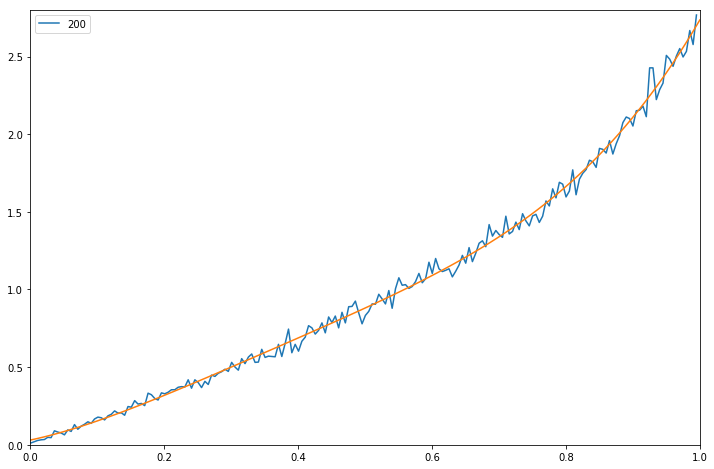

In [27]:
pdf_dist1, pdf_bins1 = np.histogram(samples_angle, bins = 20, weights = len(samples_angle)*[scale_angle], density  = True)
pdf_dist2, pdf_bins2 = np.histogram(samples_angle, bins = 50, weights = len(samples_angle)*[scale_angle], density  = True)
pdf_dist3, pdf_bins3 = np.histogram(samples_angle, bins = 100, weights = len(samples_angle)*[scale_angle], density  = True)
pdf_dist4, pdf_bins4 = np.histogram(samples_angle, bins = 200, weights = len(samples_angle)*[scale_angle], density  = True)




fig3 = plt.figure(figsize=(12,8))
ax3 = fig3.add_subplot(1,1,1)

#plt.plot(pdf_bins1[:20], pdf_dist1, label = "20")
#plt.plot(pdf_bins2[:50], pdf_dist2, label = "50")
#plt.plot(pdf_bins3[:100], pdf_dist3, label = "100")
plt.plot(pdf_bins4[:200], pdf_dist4, label = "200")
plt.legend()


coeff = np.polyfit(pdf_bins4[:200], pdf_dist4, 4)
plt.plot(np.linspace(0, 1, 100), np.polyval(coeff, np.linspace(0, 1, 100)))
plt.xlim(0,1)
plt.ylim(0,2.8)

In [26]:
print(np.trapz(np.polyval(coeff, np.linspace(0, 1, 100)), np.linspace(0, 1, 100)))
print (coeff)

1.0068316289292267
[ 4.91634504 -6.93746649  3.81221346  0.9136031   0.0303348 ]
